# Melanoma cancer detection

### Import python librairies

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import random as rd
import numpy as np
import cv2

import keras
from keras.utils import to_categorical
from keras import Sequential
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import DenseNet169
from keras.layers import Dense, GlobalAveragePooling2D, Flatten, Dropout
from keras import Model, Input

K.tensorflow_backend._get_available_gpus()


[]

### Raw Data visualisation

In [5]:
df = pd.read_csv("gt_data.csv")

In [6]:
df[df["diagnosis"]!="unknown"]

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0
12,ISIC_0076995,IP_2235340,female,55.0,torso,nevus,benign,0
26,ISIC_0084086,IP_4023055,male,60.0,lower extremity,nevus,benign,0
27,ISIC_0084270,IP_2961528,male,40.0,lower extremity,nevus,benign,0
28,ISIC_0084395,IP_0175539,female,45.0,torso,nevus,benign,0
...,...,...,...,...,...,...,...,...
33108,ISIC_9995691,IP_2358028,male,50.0,upper extremity,nevus,benign,0
33113,ISIC_9997614,IP_1705144,female,50.0,upper extremity,nevus,benign,0
33117,ISIC_9998682,IP_2516168,male,60.0,head/neck,melanoma,malignant,1
33118,ISIC_9998937,IP_3091321,male,40.0,head/neck,nevus,benign,0


In [7]:
# initial data clean
data = df[df["diagnosis"]!="unknown"]
# print data dimensions
print("data shape: {}".format(data.shape))
# print labelled data
print('\n > Present diagnosis')
for diag_type in data.diagnosis.unique():
    print("number of {}: {}".format(diag_type, len(data[data['diagnosis']==diag_type])))

print('\n > Benign/Malignant')
for diag_type in data.benign_malignant.unique():
    print("number of {}: {}".format(diag_type, len(data[data['benign_malignant']==diag_type])))

data shape: (6002, 8)

 > Present diagnosis
number of nevus: 5193
number of melanoma: 584
number of seborrheic keratosis: 135
number of lentigo NOS: 44
number of lichenoid keratosis: 37
number of solar lentigo: 7
number of cafe-au-lait macule: 1
number of atypical melanocytic proliferation: 1

 > Benign/Malignant
number of benign: 5418
number of malignant: 584


In [8]:
### Define project variables
projdir = '/Users/JG/Desktop/melanome'
datadir = os.path.join(projdir, 'data')
traindir = os.path.join(datadir, 'train')
testdir = os.path.join(datadir, 'test')

In [9]:
def display_examples(df):
    fig, axs = plt.subplots(4,4, constrained_layout = True, figsize= (15,15))
    for ax in axs.flat:
        number = int(rd.choice(df.index))
        patient_name = df['image_name'][number]
        img = plt.imread(os.path.join(traindir, patient_name + '.jpg'))
        ax.imshow(img)
        ax.set_title("{},\n diagnosis: {} {}".format(patient_name, df['benign_malignant'][number], df['diagnosis'][number]))
    plt.show()

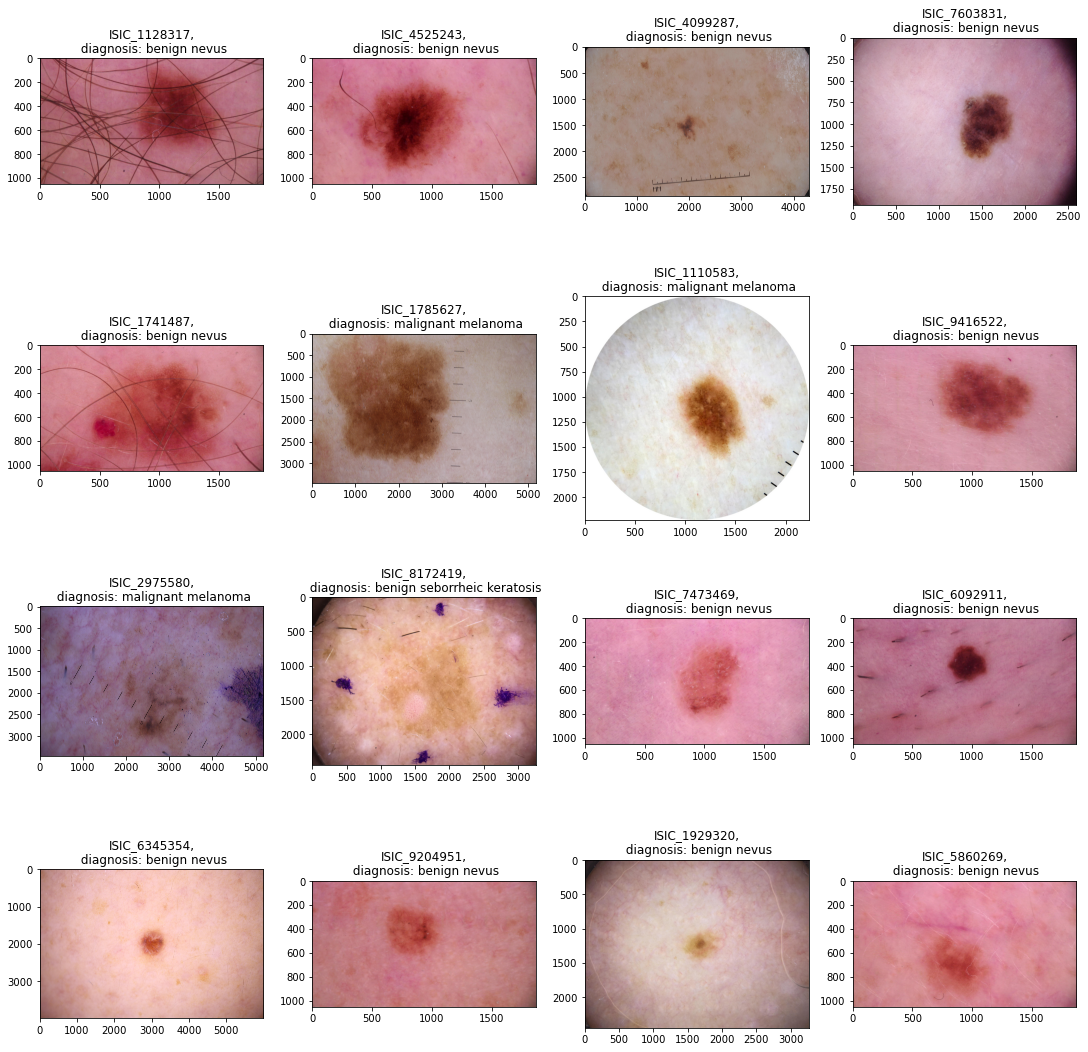

In [10]:
display_examples(data)

In [11]:
class Patient:
    def __init__(self, img, diagnosis, benign_malignant, img_name):
        self.img = img
        self.diagnosis = diagnosis
        self.case = benign_malignant
        self.name = img_name
    
    def normalise(self):
        """
        normalise images so each pixel value is between 0 and 1
        """
        self.img = self.img / np.max(self.img)
    
    def resize(self, img_size):
        """
        resize image to img_size x img_size (224x224) for DenseNet input
        """
        self.img = cv2.resize(self.img, (img_size, img_size))
        

In [12]:
nb_mal = len(data[data['benign_malignant']=='malignant'])
IMG_SIZE = 224

malignant_df = data[data['benign_malignant']=='malignant']
benign_df = data[data['benign_malignant']=='benign']

malignant_vec = []
for i in malignant_df.index:
    patient_name = malignant_df['image_name'][i]
    img = plt.imread(os.path.join(traindir, patient_name + '.jpg'))
    patient = Patient(img, malignant_df['diagnosis'][i], malignant_df['benign_malignant'][i], patient_name)
    patient.resize(IMG_SIZE)
    patient.normalise()
    malignant_vec.append(patient)
    
benign_vec = []
sample_idx = rd.choices(benign_df.index, k=nb_mal)
for i in sample_idx:
    patient_name = benign_df['image_name'][i]
    img = plt.imread(os.path.join(traindir, patient_name + '.jpg'))
    patient = Patient(img, benign_df['diagnosis'][i], benign_df['benign_malignant'][i], patient_name)
    patient.resize(IMG_SIZE)
    patient.normalise()
    benign_vec.append(patient)

In [13]:
train_val_limit = 0.8
X_train = []
y_train = []
X_val = []
y_val = []

# benign --> 0
# malignant --> 1

for i in range(int(train_val_limit*len(malignant_vec))):
    X_train.append(malignant_vec[i].img)
    y_train.append(1)

for i in range(int(train_val_limit*len(benign_vec))):
    X_train.append(benign_vec[i].img)
    y_train.append(0)
    
for i in range(int(train_val_limit*len(malignant_vec)), len(malignant_vec)):
    X_val.append(malignant_vec[i].img)
    y_val.append(1)

for i in range(int(train_val_limit*len(benign_vec)), len(benign_vec)):
    X_val.append(benign_vec[i].img)
    y_val.append(0)
    
X_train = np.array(X_train).reshape(-1, IMG_SIZE, IMG_SIZE, 3)
X_val = np.array(X_val).reshape(-1, IMG_SIZE, IMG_SIZE, 3)

y_train = to_categorical(y_train, 2)
y_val = to_categorical(y_val, 2)

In [23]:
train_datagen = ImageDataGenerator(
        rotation_range=30,
        width_shift_range=0.10,
        height_shift_range=0.10,
        shear_range=0.10,
        zoom_range=0.10,
        fill_mode='mirror',
        horizontal_flip=True,
        vertical_flip=True
        )

val_datagen = ImageDataGenerator(horizontal_flip= True)

batch_size = 16

train_generator = train_datagen.flow(X_train, y_train, batch_size = batch_size)
validation_generator = val_datagen.flow(X_val, y_val, batch_size = batch_size)

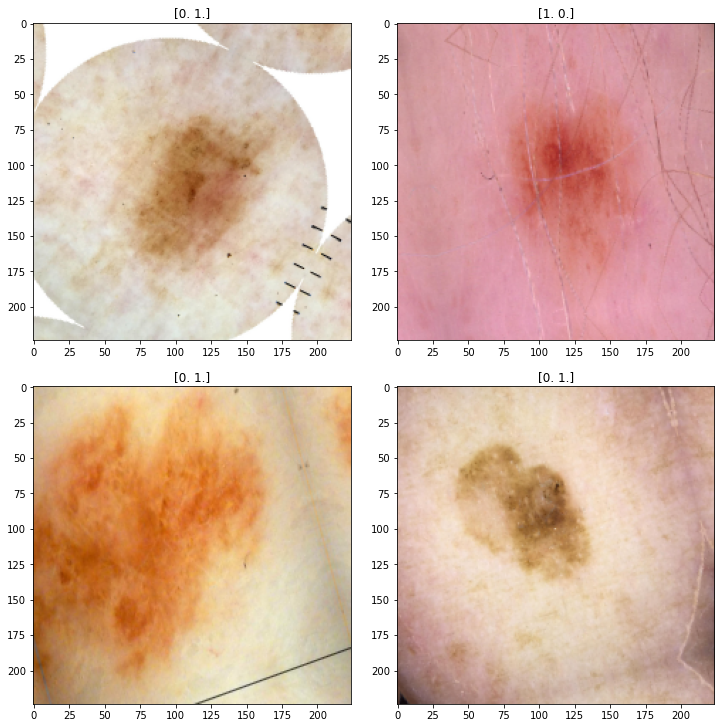

In [17]:
grid = int(np.sqrt(batch_size))
for X_batch, y_batch in train_datagen.flow(X_train, y_train, batch_size = batch_size):
    fig, axs = plt.subplots(grid,grid, constrained_layout = True, figsize= (10,10))
    for i in range(batch_size):
        ax = axs.flat[i]
        ax.imshow(X_batch[i].squeeze())
        ax.set_title(y_batch[i])
    plt.show()
    break

In [39]:
# # base model is DenseNet169 architecture without final top layer in order to load in imagenet weights
# base_model = DenseNet169 (include_top=False, weights='imagenet', input_shape=(IMG_SIZE, IMG_SIZE, 3))
# base_model.trainable = True
# # add on final FC layer
# add_model = Sequential()
# add_model.add(Flatten(input_shape=base_model.output_shape[1:]))
# add_model.add(Dense(256, activation='relu'))
# add_model.add(Dropout(0.2))
# add_model.add(Dense(2, activation='softmax'))
# model = Model(inputs = base_model.input, outputs = add_model(base_model.output))

model = DenseNet169(include_top = True, weights = None, pooling = 'max', classes = 2)

optimizer = keras.optimizers.Adam(lr=0.00001)

model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy']
             )

In [42]:
history = model.fit_generator(train_generator,
                    validation_data=validation_generator,  # pass test set as validation
                    steps_per_epoch=len(train_generator)//batch_size,  # lengthen because we have a lot of data aug
                    epochs = 100,
                    verbose=1)

Epoch 1/100
3/3 [==============================] - 68s 23s/step - loss: 0.3707 - accuracy: 0.8333 - val_loss: 0.6492 - val_accuracy: 0.5000
Epoch 2/100
3/3 [==============================] - 70s 23s/step - loss: 0.3393 - accuracy: 0.7917 - val_loss: 0.7079 - val_accuracy: 0.5000
Epoch 3/100
3/3 [==============================] - 69s 23s/step - loss: 0.2695 - accuracy: 0.8958 - val_loss: 0.7495 - val_accuracy: 0.5000
Epoch 4/100
3/3 [==============================] - 69s 23s/step - loss: 0.5650 - accuracy: 0.7708 - val_loss: 0.6215 - val_accuracy: 0.5000
Epoch 5/100
3/3 [==============================] - 76s 25s/step - loss: 0.3938 - accuracy: 0.7917 - val_loss: 0.8327 - val_accuracy: 0.5000
Epoch 6/100
3/3 [==============================] - 71s 24s/step - loss: 0.4189 - accuracy: 0.8333 - val_loss: 0.9542 - val_accuracy: 0.5000
Epoch 7/100
3/3 [==============================] - 71s 24s/step - loss: 0.3569 - accuracy: 0.8333 - val_loss: 0.7119 - val_accuracy: 0.5000
Epoch 8/100
3/3 [===

3/3 [==============================] - 72s 24s/step - loss: 0.4744 - accuracy: 0.7708 - val_loss: 1.9854 - val_accuracy: 0.5000
Epoch 60/100
3/3 [==============================] - 72s 24s/step - loss: 0.3743 - accuracy: 0.8750 - val_loss: 1.3016 - val_accuracy: 0.5000
Epoch 61/100
3/3 [==============================] - 72s 24s/step - loss: 0.3502 - accuracy: 0.8542 - val_loss: 0.9193 - val_accuracy: 0.4957
Epoch 62/100
3/3 [==============================] - 72s 24s/step - loss: 0.4288 - accuracy: 0.7708 - val_loss: 1.4086 - val_accuracy: 0.5085
Epoch 63/100
3/3 [==============================] - 72s 24s/step - loss: 0.3807 - accuracy: 0.8333 - val_loss: 0.8636 - val_accuracy: 0.5128
Epoch 64/100
3/3 [==============================] - 72s 24s/step - loss: 0.2482 - accuracy: 0.9792 - val_loss: 1.5834 - val_accuracy: 0.5043
Epoch 65/100
3/3 [==============================] - 72s 24s/step - loss: 0.3617 - accuracy: 0.8333 - val_loss: 1.4695 - val_accuracy: 0.5085
Epoch 66/100
3/3 [========

In [32]:
def plot_history():
    plt.subplot(121)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')

    plt.subplot(122)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

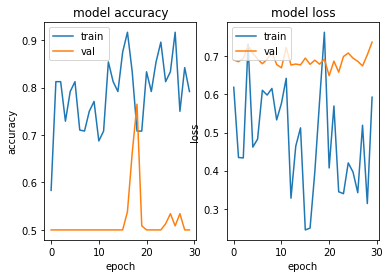

In [41]:
plot_history()